<a href="https://colab.research.google.com/github/nathanianah/MBTI-Handwriting/blob/main/MBTI_Classification_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# Any results you write to the current directory are saved as output.

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
BASE_PATH = '/content/drive/MyDrive/MBTI-Handwriting/'

In [ ]:
image=[]
labels=[]
for file in os.listdir(BASE_PATH):
    for x in ["ISTJ", "ISFJ", "INFJ", "INTJ", "ISTP", "ISFP", "INFP", "INTP", "ESTP", "ESFP", "ENFP", "ENTP", "ESTJ", "ESFJ", "ENFJ", "ENTJ"]:
      if file==x:
          for c in os.listdir(os.path.join(BASE_PATH, file)):
              if c!='annotations':
                  image.append(c)
                  labels.append(x)
    # if file=='INFJ':
    #     for c in os.listdir(os.path.join(BASE_PATH, file)):
    #         if c!='annotations':
    #             image.append(c)
    #             labels.append('INFJ')
    # if file=='ISFJ':
    #     for c in os.listdir(os.path.join(BASE_PATH, file)):
    #         if c!='annotations':
    #             image.append(c)
    #             labels.append('ISFJ')
    # if file=='ISTP':
    #     for c in os.listdir(os.path.join(BASE_PATH, file)):
    #         if c!='annotations':
    #             image.append(c)
    #             labels.append('ISTP')
data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
data.head()

,Images,labels
0,U0041_004.png,INFP
1,U0061_014.png,INFP
2,U0041_035.png,INFP
3,U0061_004.png,INFP
4,U0041_014.png,INFP


In [ ]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,labels,encoded_labels
0,U0041_004.png,INFP,5
1,U0061_014.png,INFP,5
2,U0041_035.png,INFP,5
3,U0061_004.png,INFP,5
4,U0041_014.png,INFP,5


In [ ]:
batch_size = 20
validation_split = .3
shuffle_dataset = True
random_seed= 42

In [ ]:
# Creating data indices for training and validation splits:
# from sklearn.model_selection import train_test_split
# tr, val = train_test_split(data.label, stratify=data.label, test_size=0.1)
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
#train_indices is equivalent to list(tr.index)
#val_indices is equivalent to list(val.index)

In [ ]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
class MBTI_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image = image.convert('RGB')
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
dataset = MBTI_Dataset(data,BASE_PATH,transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

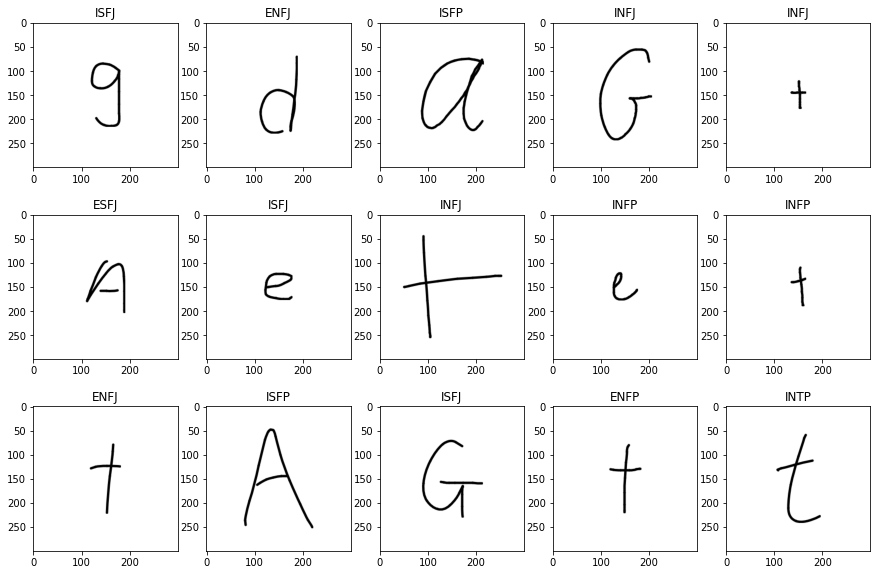

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

mbti_types = {0: 'ENFJ', 1: 'ENFP', 2: 'ENTJ', 3: 'ESFJ', 4: 'INFJ', 5: 'INFP', 6: 'INTJ', 7: 'INTP', 8: 'ISFJ', 9: 'ISFP', 10: 'ISTP'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{mbti_types[label.item()]}") # add label

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 16)
        
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False).to(device) # On CPU
#model = Net().to(device)  # On GPU
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [ ]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [ ]:
n_epochs = 20
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/20], Step [0/28], Loss: 6.9824
Epoch [1/20], Step [20/28], Loss: 4.3279

train loss: 5.1391, train acc: 16.3004
validation loss: 4.6224, validation acc: 14.1026

Detected network improvement, saving current model
Epoch 2

Epoch [2/20], Step [0/28], Loss: 3.4506
Epoch [2/20], Step [20/28], Loss: 2.3795

train loss: 3.9349, train acc: 27.4725
validation loss: 3.6126, validation acc: 25.6410

Detected network improvement, saving current model
Epoch 3

Epoch [3/20], Step [0/28], Loss: 1.9276
Epoch [3/20], Step [20/28], Loss: 1.9664

train loss: 3.2334, train acc: 45.2381
validation loss: 3.0743, validation acc: 43.5897

Detected network improvement, saving current model
Epoch 4

Epoch [4/20], Step [0/28], Loss: 1.2977
Epoch [4/20], Step [20/28], Loss: 1.1327

train loss: 2.6973, train acc: 73.6264
validation loss: 2.8242, validation acc: 38.4615

Epoch 5

Epoch [5/20], Step [0/28], Loss: 0.5792
Epoch [5/20], Step [20/28], Loss: 0.4856

train loss: 2.2644, train acc: 90.65

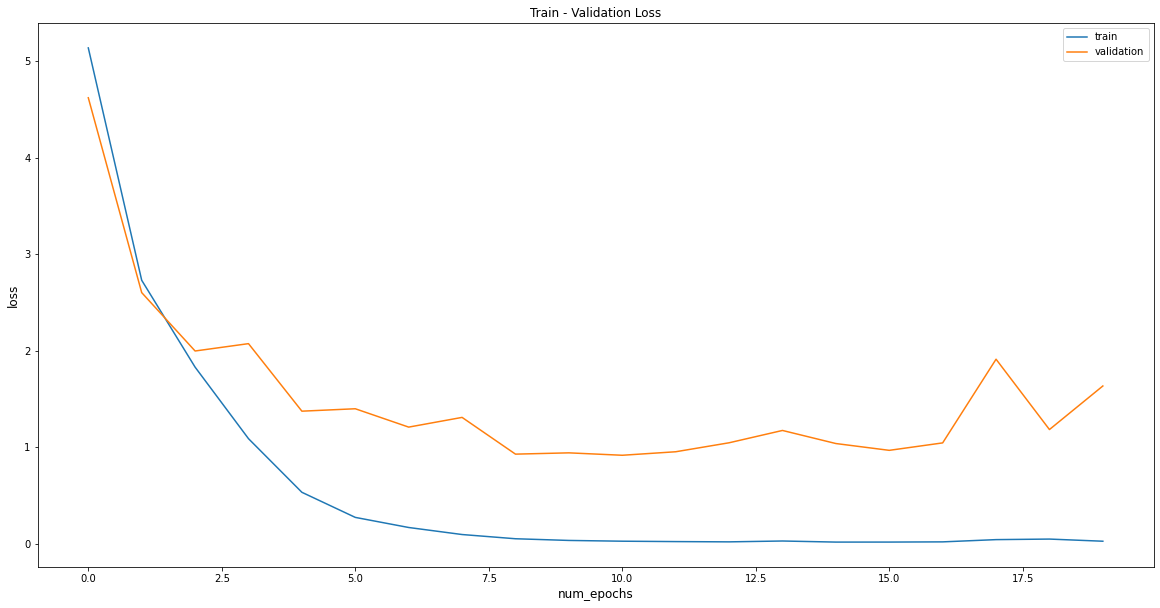

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

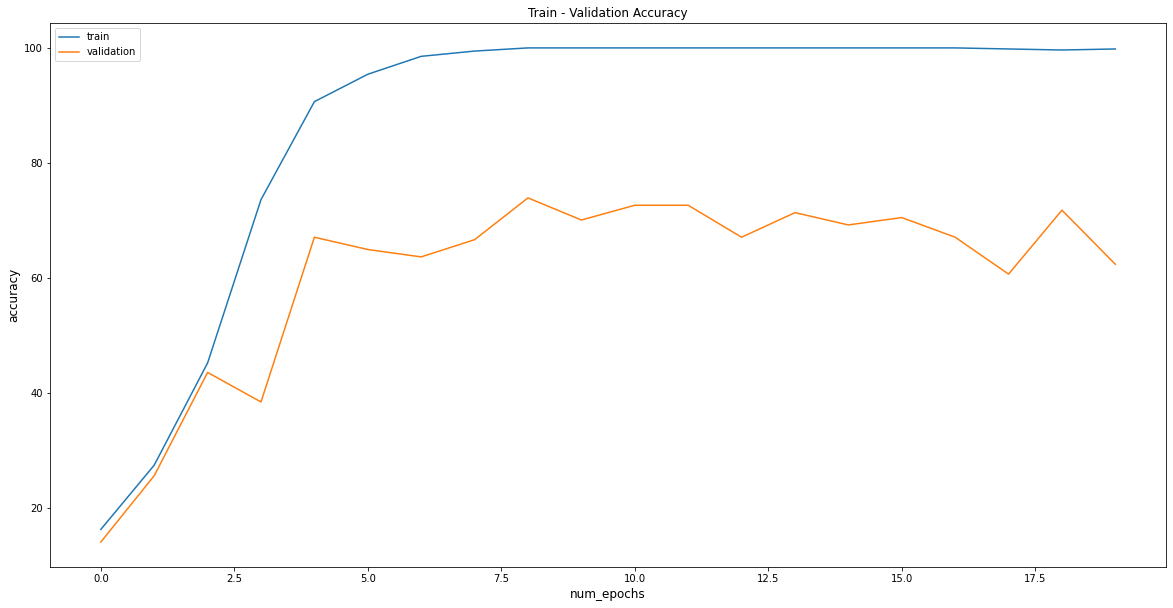

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('model_classification_tutorial.pt'))

<All keys matched successfully>

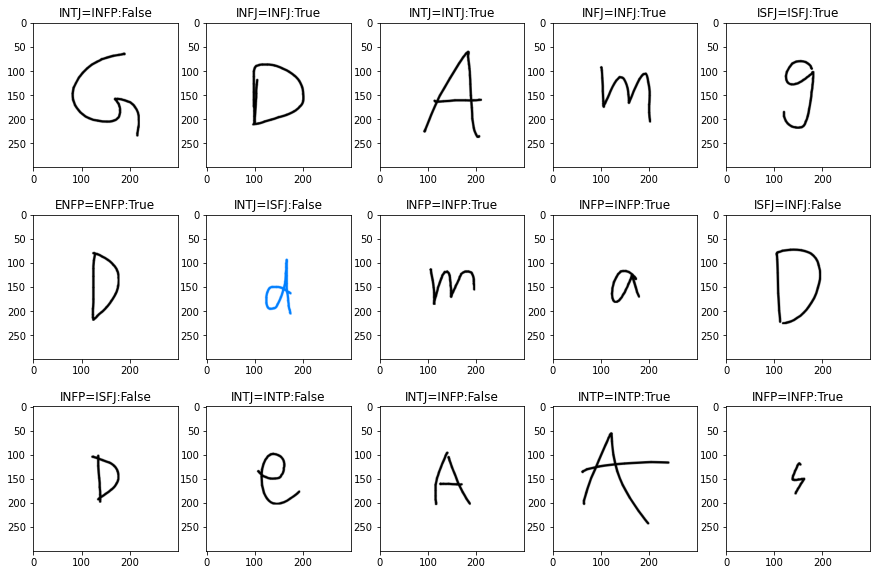

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
mbti_types = {0: 'ENFJ', 1: 'ENFP', 2: 'ENTJ', 3: 'ESFJ', 4: 'INFJ', 5: 'INFP', 6: 'INTJ', 7: 'INTP', 8: 'ISFJ', 9: 'ISFP', 10: 'ISTP'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor.to(device))
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(mbti_types[output_.item()])+"="+str(mbti_types[label.item()])+":" +str(k)) # add label

In [ ]:
def accuracy(output, target, topk=(5,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0)
        # print(correct_k)
        res.append(correct_k.mul_(100.0 / batch_size))
    # print(res)
    return res
# model.eval()
correct_5=0
count = 0
for data_t, target_t in (validation_loader):
    data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
    outputs_t = model(data_t)
    loss_t = criterion(outputs_t, target_t)
    batch_loss += loss_t.item()
    _,pred_t = torch.max(outputs_t, dim=1)
    correct_t += torch.sum(pred_t==target_t).item()
    total_t += target_t.size(0)
    acc=accuracy(outputs_t, target_t)
    correct_5+=acc[0]
    count += 1
print(correct_5/count)
val_acc=100 * correct_t / total_t
# print (top1/total_t)
print(val_acc)

tensor(89.8214, device='cuda:0')
69.23076923076923
